# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernible landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import os
import numpy as np
import torch
from PIL import Image

#settings
num_workers = 0
batch_size = 20
valid_size = 0.2
root_path = os.path.join(os.getcwd(), "landmark_images")
train_path = os.path.join(root_path, "train")
test_path = os.path.join(root_path, "test")
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])
scale_size = 318
crop_size = 224
rotation = 90
output_classes = 50

#transform
def create_train_transform(scale_size, crop_size, rotation, mean, std):
    return transforms.Compose([
        transforms.Resize(scale_size),
        transforms.RandomRotation(rotation),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(crop_size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

def create_test_tranform(crop_size, mean, std):
    return transforms.Compose([
        transforms.CenterCrop(crop_size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

train_transform = create_train_transform(scale_size, crop_size, rotation, mean, std)
test_transform = create_test_tranform(crop_size, mean, std)

clear_transform = transforms.Compose([
    transforms.Lambda(lambda img: img / 2 + 0.5),
    transforms.Lambda(lambda img: np.transpose(img, (1, 2, 0)))
])

#datasets
train_dataset = datasets.ImageFolder(root=train_path, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=test_transform)

#sampler
num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

#data loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         num_workers=num_workers)

loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: First, the code scales the input image to 318 pixels followed by a center crop of 224 pixels.  
I chose a final size of 224 pixels, in order to make the first CNN linear layer not become too large. 
The scaling value of 318 pixels is large enough for a possible 45 degree rotation without black borders.
After inspecting the train data I chose to use data augementation for building a more robust net.
Within the training data there were e.g. rotated train images with a rotation of 90 degrees or some images with text underneath that had to be clipped.

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

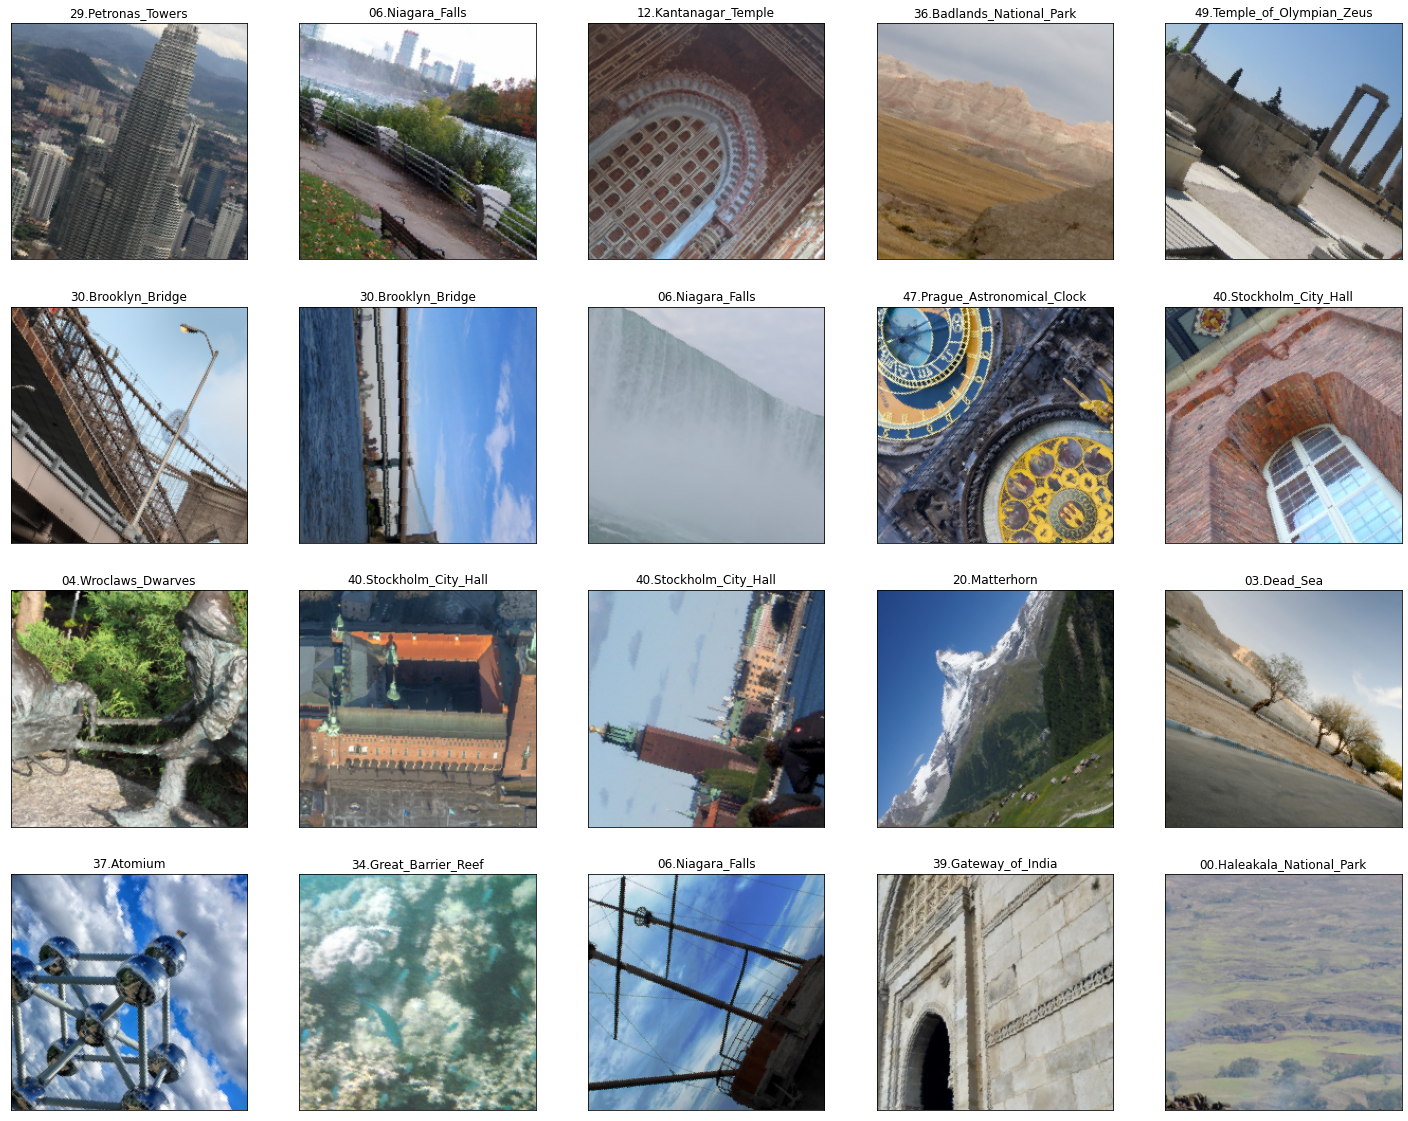

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)
images, cls_indices = iter(train_loader).next()
classes = train_dataset.classes

num_rows = 4
num_cols = int(batch_size/num_rows)
fig = plt.figure(figsize=(25,20))

for idx in np.arange(batch_size):
    ax = fig.add_subplot(num_rows, num_cols, idx+1, xticks=[], yticks=[])
    image = images[idx]
    image = clear_transform(image)
    plt.imshow(image)
    cls_idx = cls_indices[idx]
    ax.set_title(classes[cls_idx])


### Initialize use_cuda variable

In [3]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [4]:
## TODO: select loss function
import torch.optim as optim

criterion_scratch = torch.nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    return optim.SGD(model.parameters(), lr=0.01)


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [5]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 8, 3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1, stride=1)
        self.conv3 = nn.Conv2d(16, 24, 3, padding=1, stride=1)
        self.pool1 = nn.MaxPool2d(4,4)
        self.pool2 = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(24 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, output_classes)
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        ## Define forward behavior
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        
        x = F.relu(self.conv3(x))
        x = self.pool2(x)

        x = x.view(-1, 24 * 7 * 7)        
        x = self.dropout(x)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__   
- First, I inspected several sources to get inspiritions for the net architecture. 
- The initial idee was to use 2-3 convolutional layers with a following linear layer with 
an input size of around 1000.
- Then, I tried a few versions with different kernel and pool sizes and found a promising size for
the linear layer of 24 * 7 * 7.
- I used dropout layers to reduce overfitting.
- I chose the output size to detect 50 different classes.


### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [11]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            

        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)
           
        train_loss = train_loss/len(loaders['train'].sampler)
        valid_loss = valid_loss/len(loaders['valid'].sampler)
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [7]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    classname = m.__class__.__name__
    if classname.find("Linear") != -1:
        n = m.in_features
        if n != 0:
            y = (1.0 / np.sqrt(n))
            m.weight.data.normal_(0, y)
            m.bias.data.fill_(0)

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 3.911735 	Validation Loss: 3.908739
Epoch: 2 	Training Loss: 3.911624 	Validation Loss: 3.907174
Epoch: 3 	Training Loss: 3.908727 	Validation Loss: 3.904310
Epoch: 4 	Training Loss: 3.905378 	Validation Loss: 3.900360
Epoch: 5 	Training Loss: 3.898904 	Validation Loss: 3.890465
Epoch: 6 	Training Loss: 3.891117 	Validation Loss: 3.876464
Epoch: 7 	Training Loss: 3.876799 	Validation Loss: 3.856212
Epoch: 8 	Training Loss: 3.865558 	Validation Loss: 3.837855
Epoch: 9 	Training Loss: 3.848332 	Validation Loss: 3.832216
Epoch: 10 	Training Loss: 3.840583 	Validation Loss: 3.818393
Epoch: 11 	Training Loss: 3.829313 	Validation Loss: 3.801622
Epoch: 12 	Training Loss: 3.818896 	Validation Loss: 3.795570
Epoch: 13 	Training Loss: 3.799501 	Validation Loss: 3.782432
Epoch: 14 	Training Loss: 3.788135 	Validation Loss: 3.778759
Epoch: 15 	Training Loss: 3.779174 	Validation Loss: 3.753438
Epoch: 16 	Training Loss: 3.765724 	Validation Loss: 3.740942
Epoch: 17 	Traini

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [8]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 150

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.912070 	Validation Loss: 3.911981
Epoch: 2 	Training Loss: 3.911664 	Validation Loss: 3.911542
Epoch: 3 	Training Loss: 3.911256 	Validation Loss: 3.911263
Epoch: 4 	Training Loss: 3.910807 	Validation Loss: 3.910493
Epoch: 5 	Training Loss: 3.909891 	Validation Loss: 3.910133
Epoch: 6 	Training Loss: 3.909292 	Validation Loss: 3.908963
Epoch: 7 	Training Loss: 3.907910 	Validation Loss: 3.907060
Epoch: 8 	Training Loss: 3.906461 	Validation Loss: 3.904659
Epoch: 9 	Training Loss: 3.903925 	Validation Loss: 3.900515
Epoch: 10 	Training Loss: 3.899303 	Validation Loss: 3.892403
Epoch: 11 	Training Loss: 3.889690 	Validation Loss: 3.876444
Epoch: 12 	Training Loss: 3.871978 	Validation Loss: 3.844366
Epoch: 13 	Training Loss: 3.838913 	Validation Loss: 3.806805
Epoch: 14 	Training Loss: 3.814179 	Validation Loss: 3.788072
Epoch: 15 	Training Loss: 3.801816 	Validation Loss: 3.775621
Epoch: 16 	Training Loss: 3.783787 	Validation Loss: 3.758308
Epoch: 17 	Traini

Epoch: 133 	Training Loss: 2.074496 	Validation Loss: 2.925974
Epoch: 134 	Training Loss: 2.052627 	Validation Loss: 2.875834
Epoch: 135 	Training Loss: 2.070672 	Validation Loss: 2.880287
Epoch: 136 	Training Loss: 2.043195 	Validation Loss: 3.222855
Epoch: 137 	Training Loss: 2.040057 	Validation Loss: 2.939002
Epoch: 138 	Training Loss: 2.010254 	Validation Loss: 2.934136
Epoch: 139 	Training Loss: 2.024913 	Validation Loss: 2.995076
Epoch: 140 	Training Loss: 2.034942 	Validation Loss: 2.928402
Epoch: 141 	Training Loss: 1.998653 	Validation Loss: 2.946242
Epoch: 142 	Training Loss: 1.993619 	Validation Loss: 2.961801
Epoch: 143 	Training Loss: 1.995339 	Validation Loss: 2.889654
Epoch: 144 	Training Loss: 1.950315 	Validation Loss: 2.962902
Epoch: 145 	Training Loss: 1.989260 	Validation Loss: 2.978268
Epoch: 146 	Training Loss: 1.952532 	Validation Loss: 2.941932
Epoch: 147 	Training Loss: 1.961398 	Validation Loss: 2.922045
Epoch: 148 	Training Loss: 1.947481 	Validation Loss: 2

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [12]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.294569


Test Accuracy: 24% (305/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [13]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

#transform
transfer_train_transform = create_train_transform(scale_size, crop_size, rotation, mean, std)
transfer_test_transform = create_test_tranform(crop_size, mean, std)

#datasets
transfer_train_dataset = datasets.ImageFolder(root=train_path, transform=transfer_train_transform)
transfer_test_dataset = datasets.ImageFolder(root=test_path, transform=transfer_test_transform)

#data loader
transfer_train_loader = torch.utils.data.DataLoader(transfer_train_dataset, batch_size=batch_size,
                                          sampler=train_sampler, num_workers=num_workers)
transfer_valid_loader = torch.utils.data.DataLoader(transfer_train_dataset, batch_size=batch_size,
                                          sampler=valid_sampler, num_workers=num_workers)
transfer_test_loader = torch.utils.data.DataLoader(transfer_test_dataset, batch_size=batch_size,
                                         num_workers=num_workers)

loaders_transfer = {'train': transfer_train_loader, 'valid': transfer_valid_loader, 'test': transfer_test_loader}


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [18]:
## TODO: select loss function
criterion_transfer = torch.nn.CrossEntropyLoss()


def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    return optim.SGD(model.classifier.parameters(), lr=0.01)
    
    

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [19]:
## TODO: Specify model architecture
from torchvision import models

model_transfer = models.vgg16(pretrained=True)

for param in model_transfer.features.parameters():
    param.requires_grad = False

n_inputs = model_transfer.classifier[6].in_features
n_outputs = output_classes

last_layer = nn.Linear(n_inputs, n_outputs)
model_transfer.classifier[6] = last_layer

#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  
 - I chose the pretrained vgg 16 model, because I wanted to use a model being able to solve
 the minimum requirement of 60% accuracy within an acceptable time frame. With a higher requirement I 
 would have chosen a different model version with more layers, but with the expectation of achieving a higher accuracy
 while requiring a longer training time.
 - I assumed this trained model to be be able to detect the rough shapes and colors and
 that a new classifier would be able to be good enough, even with a much smaller trainset.
 - I chose to freeze the weights of the pretrained net and to train only the new classifier.

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [20]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
num_epochs_transfer = 20

model_transfer = train(num_epochs_transfer, loaders_transfer, model_transfer, 
                               get_optimizer_transfer(model_transfer), 
                               criterion_transfer, use_cuda, 'model_transfer.pt')

#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 2.611375 	Validation Loss: 1.848053
Epoch: 2 	Training Loss: 1.796156 	Validation Loss: 1.622300
Epoch: 3 	Training Loss: 1.544536 	Validation Loss: 1.539853
Epoch: 4 	Training Loss: 1.372525 	Validation Loss: 1.467671
Epoch: 5 	Training Loss: 1.275320 	Validation Loss: 1.387997
Epoch: 6 	Training Loss: 1.160210 	Validation Loss: 1.392426
Epoch: 7 	Training Loss: 1.079857 	Validation Loss: 1.371438
Epoch: 8 	Training Loss: 1.005552 	Validation Loss: 1.342766
Epoch: 9 	Training Loss: 0.960170 	Validation Loss: 1.357689
Epoch: 10 	Training Loss: 0.909224 	Validation Loss: 1.314863
Epoch: 11 	Training Loss: 0.869713 	Validation Loss: 1.340936
Epoch: 12 	Training Loss: 0.825306 	Validation Loss: 1.266806
Epoch: 13 	Training Loss: 0.773961 	Validation Loss: 1.331001
Epoch: 14 	Training Loss: 0.732510 	Validation Loss: 1.338635
Epoch: 15 	Training Loss: 0.688662 	Validation Loss: 1.320274
Epoch: 16 	Training Loss: 0.675183 	Validation Loss: 1.307844
Epoch: 17 	Traini

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [21]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.222583


Test Accuracy: 66% (836/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [22]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    with Image.open(img_path) as pil_image:
        image = transfer_test_transform(pil_image)        
        batch = torch.unsqueeze(image, 0)

        if use_cuda:
            image = image.cuda()
            batch = batch.cuda()
            model_transfer.cuda()
        
        model_transfer.eval()
        output = model_transfer(batch)

        top_ps, top_classes = output.topk(k=k, dim=1)
        top_ps = top_ps.detach()
        
        top_ps = top_ps.cpu()
        top_ps = top_ps.numpy()[0]
        top_classes = top_classes.cpu() 
        top_classes = top_classes.numpy()[0]
        
        transfer_classes = transfer_train_dataset.classes
        labels = [transfer_classes[idx] for idx in top_classes]
        labels = [label.split(".")[1] for label in labels]
        labels = [label.replace("_", " ") for label in labels]

        return labels
        
# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['Golden Gate Bridge',
 'Brooklyn Bridge',
 'Forth Bridge',
 'Sydney Harbour Bridge',
 'Niagara Falls']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

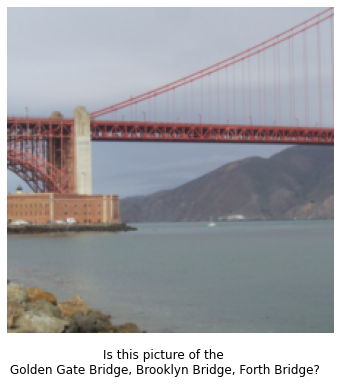

In [23]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions
    suptitle = "Is this picture of the \n" + ", ".join(predicted_landmarks) + "?"
    
    img_suggest_transform =  transforms.Compose([
        transforms.Resize(scale_size),
        transforms.CenterCrop(crop_size)])

    with Image.open(img_path) as pil_image:
        pil_image = img_suggest_transform(pil_image)
        fig = plt.figure(figsize=(6,6))
        ax = plt.imshow(pil_image)
        plt.axis('off')
        pred_text_args = (0.5, 0.03, suptitle)
        pred_text_kwargs = dict(horizontalalignment ="center", fontsize = 12)
        plt.figtext(*pred_text_args, **pred_text_kwargs)

    
# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)
 
 Providing two correct classifications and two nearly correct classification the output is
 better than expected.
 
 Possible improvements could be:
 - Using further transforms for data augmentation.
 - Training the net with a more precise learning rate.
 - Building a deeper net with more layers.

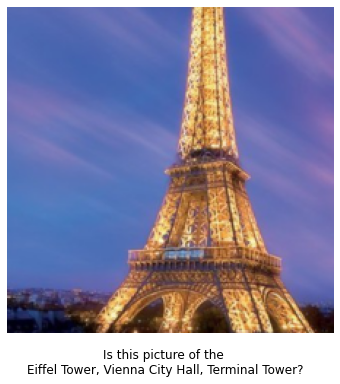

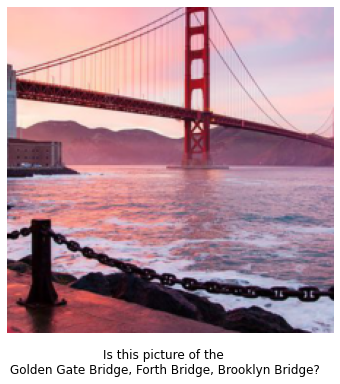

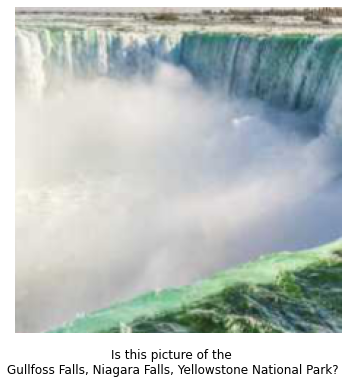

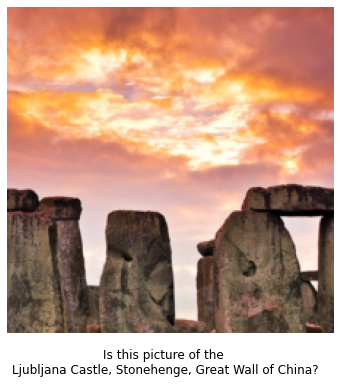

In [24]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.

suggest_locations('images/eiffel_tower.jpg')
suggest_locations('images/golden_gate_bridge.jpg')
suggest_locations('images/niagara_falls.jpg')
suggest_locations('images/stonehenge.jpg')